## Imports

In [1]:
import numpy as np
from numpy import pi, cos, sin, array

In [2]:
from scipy import signal
from scipy.linalg import toeplitz, inv

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
np.set_printoptions(precision=3, suppress=True)

In [4]:
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)

### Useful functions

In [5]:
def calculate_error_rms(x, x_est):
    error = x[:len(x_est)] - x_est
    error_rms = np.linalg.norm(error)/len(error)
    return error_rms.round(5)

## Zero Forcing Equalizer

In [6]:
x = np.random.choice([-1, 1], 40)
channel = array([.1, -.1, 0.05, 1, .05])

y = np.convolve(x, channel)

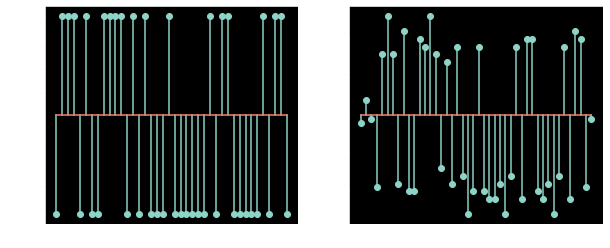

In [7]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].stem(x)
ax[1].stem(y);

In [8]:
# 6 tap equalizer
taps = 6
Y = toeplitz(y[taps-1:taps-1+taps], np.flip(y[:taps]))
zerof = inv(Y)@x[:taps]
zerof

array([-0.18 ,  0.091,  1.045, -0.356,  0.359, -0.652])

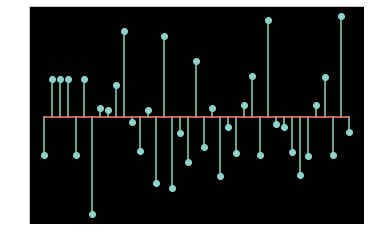

In [9]:
x_zerof = np.convolve(y, zerof, 'valid') # x_est is shorter than x because of 'valid'
plt.stem(x_zerof);

In [10]:
calculate_error_rms(x, x_zerof)

0.13205

## Least Squares Error Equalizer

In [11]:
taps = 6 
L = 30 # number of input samples used
Y = toeplitz(y[taps-1: taps-1+L ] ,np.flip(y[:taps]))
lse = inv(Y.T @ Y)@Y.T @ x[:L]
lse

array([ 0.099, -0.07 ,  1.003, -0.051,  0.011, -0.012])

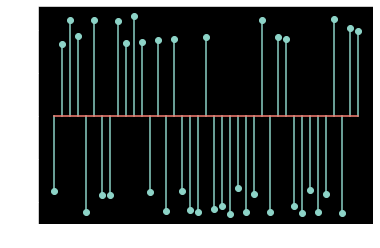

In [12]:
x_lse = np.convolve(y, lse, 'valid')
plt.stem(x_lse);

In [13]:
calculate_error_rms(x, x_lse)

0.01789

### Channel Estimation

In [14]:
L = 30 
taps = 5
X = toeplitz( x[:L], np.zeros(6) )

h_est = inv(X.T@X)@X.T@y[:L]
h_est

array([ 0.1 , -0.1 ,  0.05,  1.  ,  0.05,  0.  ])

## MMSE Equalizer

In [15]:
x_var = 1
noise_var = 1e-4 # SNR = 40 dB
channel = array([.1, -.1, .05, .9+0.1j, .05], complex) # L = 5
N = 5 # Taps in equalizer
L = len(channel)
D = N + L - 4 

In [16]:
# Calculate H 
col = np.zeros(N, complex)
col[0] = channel[0]

row = np.zeros(N+L-1, complex)
row[:L] = channel

H = toeplitz(col, row)
H.shape

(5, 9)

In [17]:
# Calculate R_y
R_x = x_var * np.eye(N+L-1)
R_v = noise_var * np.eye(N)
R_y = H @ R_x @ H.T + R_v

In [18]:
xD_x = np.zeros(N+L-1)
xD_x[D] = x_var

C = xD_x @ H.T @ inv(R_y)
C

array([-0.128+0.029j,  0.13 -0.03j , -0.069+0.016j,  1.103-0.123j,
       -0.058+0.013j])

In [19]:
corrected_channel = np.convolve(channel , C)
corrected_channel

array([-0.013+0.003j,  0.026-0.006j, -0.026+0.006j,  0.006-0.002j,
       -0.006+0.002j,  0.004-0.001j,  0.998+0.001j,  0.001-0.001j,
       -0.003+0.001j])

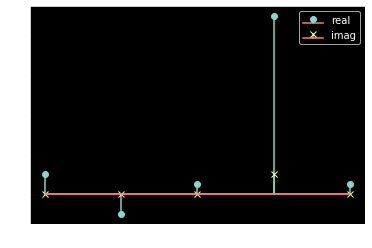

In [20]:
plt.stem(channel.real, markerfmt='o', label='real')
plt.stem(channel.imag, markerfmt='x', label='imag')
plt.legend();

In [21]:
symbols = 2000
x = (np.random.choice([-1, 1], symbols) + 1j*np.random.choice([-1, 1], symbols))*np.sqrt(x_var/2)
noise = (np.random.choice([-1, 1], symbols) + 1j*np.random.choice([-1, 1], symbols))*np.sqrt(noise_var/2)

y = np.convolve(x, channel, 'full') # This is not the same as signal.lfilter
y = y[:len(x)]
observations = y + noise

A quick note about how `np.convolve()` and `signal.lfilter()` are related.
1. 
```
y_full = np.convolve(x, channel, 'full') # size: 2004
```
2. 
```
y_same = np.convolve(x, channel, 'same') # size: 2000, 
```
This is same as `y_full[2:-2]` (drops 2 samples in the beginning and end)
3.  
```
y_filt = signal.lfilter(channel, 1, x) # size: 2000
```
This is same as `y_full[:-4]` (drops 4 samples at end)


In [22]:
estimation = signal.lfilter(C, 1, observations)

error = estimation[D:] - x[:-D]
evm_db = 10*np.log10(np.var(error)/x_var)
snr_db = 10*np.log10(np.var(y)/noise_var)
evm_rms = 100*np.sqrt( np.var(error)/x_var )

print(f'EVM: {evm_db:.2f} dB , {evm_rms:.4f} (% rms) \nSNR: {snr_db:.1f} dB')

EVM: -27.54 dB , 4.1977 (% rms) 
SNR: 39.3 dB


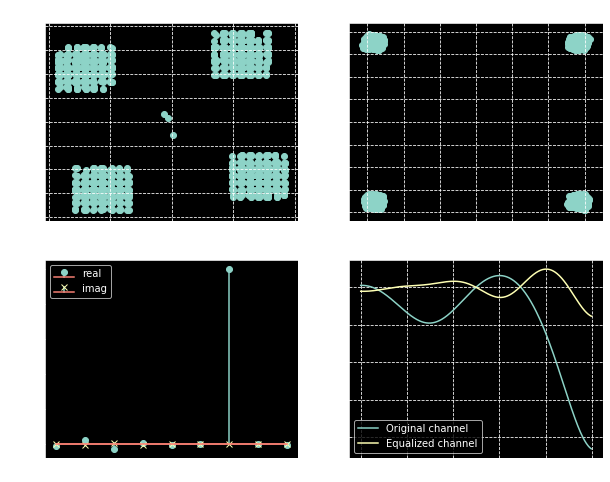

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
ax1.scatter(observations.real, observations.imag)
ax1.grid(linestyle='dashed')
ax1.set_title('Observations Y[n]')

ax2.scatter(estimation[D:].real, estimation[D:].imag);
ax2.grid(linestyle='dashed');
ax2.set_title('Estimate of x with EVM={:.2f}dB'.format(evm_db));

ax3.stem(corrected_channel.real, markerfmt='o', label='real')
ax3.stem(corrected_channel.imag, markerfmt='x', label='imag')
ax3.legend()
ax3.set_title('Corrected channel')

w, h = signal.freqz(channel, 1)
ax4.plot(w/(2*pi), 20*np.log10(abs(h)), label='Original channel')
w, h = signal.freqz(corrected_channel, 1)
ax4.plot(w/(2*pi), 20*np.log10(abs(h)), label='Equalized channel');
ax4.set_title('Magnitude Responses')
ax4.legend()
ax4.grid(linestyle='dashed');